### Implementation of Q learning for episodic win or loose scenarios 


For each game we define an action value function in therms of time given the outcome of the game
 ### $(actionXstate)(t)|Outcome$ 
 with that information we estimate and experiment with possible Q values to train a neural network. 
 In this estimation of Q we include a positive, negative reward with a discount factor defined by the length of the game.

In [184]:
from VisualModule import AgentEnvironment
from DQN_Agent import NeurosmashAgent

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize

import gym
import math
import random
from collections import namedtuple
from itertools import count
from PIL import Image
import os

from stopwatch import Stopwatch


In [185]:
model_output_dir = "output/model_output/"

if not os.path.exists(model_output_dir):
    os.makedirs(model_output_dir)

max_distance = 600
show_images = False
skip_frames = 15
state_size =  13 # agent_pos, enemy_pos, vec_agent, vec_enemy, rel_pos_enemy, done
action_size = 3
episode_count = 1000
batch_size = 32
size       = 768         # Please check the Updates section above for more details
timescale  = 10           # Please check the Updates section above for more details

In [186]:
environment = AgentEnvironment(size=size, timescale=timescale)
agent = NeurosmashAgent(state_size = state_size, action_size = action_size) # action size: move in x or y direction, or do nothing

In [187]:
def compute_reward(standard_reward, distance):
    distance_reward = (max_distance-distance)/max_distance
    total_reward = (distance_reward + standard_reward)/ 2
    return total_reward

In [188]:
def direction(agent_path, enemy_path):
    A_X = (np.array(agent_path[-1]) - np.array(agent_path[-2]))[0]
    A_Y = -(np.array(agent_path[-1]) - np.array(agent_path[-2]))[1]
    E_X = (np.array(enemy_path[-1]) - np.array(enemy_path[-2]))[0]
    E_Y = -(np.array(enemy_path[-1]) - np.array(enemy_path[-2]))[1]
    return [A_X,A_Y],[E_X,E_Y]

def do_action(action, total_steps, eval_pic):
    stopwatch = Stopwatch() 
    stopwatch.start()
    # Normalize the values 
    info, reward, agent_coord, enemy_coord, _ = environment.actionLoop(action, 0, 1)
    # Replace folowing_state with the representation

    
    stopwatch.stop()
    #print(f"Total time for do action: {stopwatch.duration}")
    if len(environment.agent_path) < 2:
        distance = 500 # Initial distance, only for initialisation
        agent_direction = [1,0] # By definition of facing each other
        enemy_direction = [-1,0]
        
    else:
        distance = np.sqrt(np.square(np.array(list(np.array(agent_coord)- np.array(enemy_coord))).sum(axis=0)))
        # Extract all variables 
        agent_direction, enemy_direction  = direction(environment.agent_path, environment.enemy_path)
    
    complete_reward = compute_reward(reward, distance)

    rel_pos_enemy = np.array(enemy_coord) - np.array(agent_coord)
    # Return a value in range 0,1 for following_state
    # Nstatus = d[0]
    # Ncomplete_reward = d[1]
    # Nagent_posx = d[2][0]/700
    # Nagent_posy = d[2][1]/700
    # Nenemy_posx = d[3][0]/700
    # Nenemy_posy = d[3][1]/700
    # Nagent_dirx = d[4][0]/60+0.5
    # Nagent_diry = d[4][1]/60+0.5
    # Nenemy_dirx = d[5][0]/60+0.5
    # Nenemy_diry = d[5][1]/60+0.5
    # Nenemy_pos_relx = d[7][0]/1400+0.5
    # Nenemy_pos_rely = d[7][1]/1400+0.5
    # Ndistance = d[6]/700
   
    d=info, complete_reward, np.array(agent_coord), np.array(enemy_coord), agent_direction, enemy_direction, distance, rel_pos_enemy
    following_state = d[0],d[1],d[2][0]/700,d[2][1]/700,d[3][0]/700,d[3][1]/700,\
     d[4][0]/60+0.5,d[4][1]/60+0.5,d[5][0]/60+0.5,d[5][1]/60+0.5,\
     d[7][0]/1400+0.5,d[7][1]/1400+0.5,d[6]/700
    
    return list(following_state)

In [189]:
def init_environment(env, agent_here):
    info, reward, state = env.reset() 
    agent_trajectories = []
    enemy_trajectories = []
    
    small_init_state = [[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], False]
    
    #for i in range(3):
    action = agent_here.act(small_init_state) # get next action
    # action = 3 (if above does not work)
    
    #pre_state_img = np.flip(np.array(state).reshape(3,256,256).transpose(1,2,0),0)
    #step_number_now = i+1
    info, complete_reward, agent_pos, enemy_pos, agent_direction, enemy_direction, distance, relative_pos_enemy, next_state = do_action(action, 1, True)  
    
    #post_state_img = np.flip(np.array(next_state).reshape(3,256,256).transpose(1,2,0),0)

    #agent_pos, enemy_pos = env_feat.coord(pre_state_img, post_state_img)
    agent_trajectories.append(list(agent_pos))
    enemy_trajectories.append(list(enemy_pos))
        
    return 

In [190]:
def view(agent_path,enemy_path):

    x_a,y_a,x_e,y_e = xyvalues(agent_path,enemy_path)
    A_dir=[]
    E_dir=[]
    Initial_a_dir = [1,0] # By definition they are facing each other
    Initial_e_dir = [-1,0]
    Game_1 = pd.DataFrame([x_a,y_a,x_e,y_e]).T
    Game = Game_1.rename(columns={0: "A_x_comp", 1: "A_y_comp",2: "E_x_comp", 3: "E_y_comp"})
    interval=1 # The interval difference to consider a trajectory 
    for i in range(len(Game)-interval):
    
        Agent_dir = pd.DataFrame(Game.iloc[i]-Game.iloc[i-interval]).iloc[0:2].values
        Enemy_dir = pd.DataFrame(Game.iloc[i]-Game.iloc[i-interval]).iloc[2:4].values
        
        Agent_dir=(Initial_a_dir[0]+normalize(Agent_dir,axis=0)[0][0])/2,(Initial_a_dir[1]+normalize(Agent_dir,axis=0)[1][0])/2
        
        Enemy_dir=(Initial_e_dir[0]+normalize(Enemy_dir,axis=0)[0][0])/2,(Initial_e_dir[1]+normalize(Enemy_dir,axis=0)[1][0])/2
    
        A_dir.append(Agent_dir)
        E_dir.append(Enemy_dir) # The direction vector is stored in A_dir, E_dir
        
    for time in range(len(A_dir)):
        V = np.array([E_dir[time]])
        origin = Game[["E_x_comp","E_y_comp"]].iloc[time].values[0],Game[["E_x_comp","E_y_comp"]].iloc[time].values[1] # origin point
        plt.quiver(*origin, V[:,0], V[:,1], color=['b'], scale=30)
    
        VA = np.array([ A_dir[time]])
        origin = Game[["A_x_comp","A_y_comp"]].iloc[time].values[0],Game[["A_x_comp","A_y_comp"]].iloc[time].values[1] # origin point
        plt.quiver(*origin, VA[:,0], VA[:,1], color=['r'], scale=30)
    
    plt.ylim(300, 768)
    plt.xlim(0, 768)
    plt.savefig('result_{}.png'.format(int(len(full_games_y))))
    plt.show()



# After all the setup we run the first agent 

# Experiment 1

In [191]:
from sklearn.neural_network import MLPRegressor
import numpy as np
import pickle
from collections import deque
# load the model from disk

#nn = pickle.load(open("model.sav", 'rb'))
from scipy.stats import logistic
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adadelta

full_games_x=pickle.load(open("his_games_x", 'rb'))

full_games_y=pickle.load(open("his_games_y", 'rb'))
nn = pickle.load(open("nn.sav", 'rb'))
#pnn = pickle.load(open("pnn.sav", 'rb'))
#nn = Sequential()
#nn.add(Dense(132, activation='relu', input_dim=12))
# nn.add(Dense(132, activation='relu'))
# nn.add(Dense(132, activation='relu'))
# nn.add(Dense(132, activation='relu'))
# nn.add(Dense(132, activation='relu'))
# nn.add(Dense(132, activation='relu'))
# nn.add(Dense(132, activation='relu'))
# nn.add(Dense(132, activation='relu'))
# nn.add(Dense(132, activation='relu'))
# nn.add(Dense(1, activation='linear'))
# nn.compile(loss='mse', optimizer=Adadelta()) # originally Adam

In [192]:
### Train the model with 
NumberOfGames=1
epsilon = 0 # zero means model, 1 random.
percentage=[]

In [193]:
u=0
for i in range(NumberOfGames):
    environment.reset() 
    F_next_state=[]
    
    F_reward=[]
    prd=[]
    u+=1
    j=1
    status=0
    action=0
    rand=True
    while status==0 or j<10:  
        if np.random.rand() <= epsilon:
            rand=True
        else:
            rand=False
        
        if rand:
            action=random.randrange(3)



        next_state = do_action(action,1,True)
        # action=NewAgent.act(1)

        status=next_state[0] # Normalized status 
        reward=next_state[1] # reward
        next_state = next_state[2:] # State variables
        next_state.append(action/2)

        F_next_state.append(next_state)
        F_reward.append(reward)
        exp_value=[]
        if rand:
                action=random.randrange(3)
        else:
            for k in range(3): # For each action 
                ex_reward=F_next_state[-1][:-1] 
                ex_reward.append(k/2)# Normalized action 
      
                prediction=nn.predict(np.array(ex_reward).reshape(1, -1))  # Will evaluate the value of the next action 
                ex_reward=[]
                exp_value.append(prediction) # First element is first action and so on 
                
            action = np.argmax(exp_value)
        if len(F_next_state)>800:
            status=1
        
        j=10
        
    if int(F_reward[-1])>4: # If he wins 
        x = F_next_state
        y = [(((len(F_reward)-i*0.5)/len(F_reward))+1)*(F_reward[i]) for i in range(len(F_reward))] # Win, label his path with a high value 
        nn.fit(np.array(x), np.array(y),epochs=5,verbose=0) 
        # Save an image 
        plt.figure()
        view(environment.agent_path[-200:-1],environment.enemy_path[-200:-1])# Train after each game
    else:
        x = F_next_state
        y = [(((len(F_reward)-i*0.5)/(len(F_reward))))*(F_reward[i]) for i in range(len(F_reward))] # label his path with a lower value 
        nn.fit(np.array(x), np.array(y),epochs=5,verbose=0)

        # Train after each game
    percentage.append([0,1,1,1,1,1][int(F_reward[-1])])
    filename = 'nn.sav'
    pickle.dump(nn, open(filename, 'wb'))
    # Save games for possible trainings 
    full_games_x.append(x)
    full_games_y.append(y)
    pickle.dump(full_games_x, open("his_games_x", 'wb'))
    pickle.dump(full_games_y, open("his_games_y", 'wb'))
    
    # Learn a model to predict the next outcome 
    # shift_F_next_state=deque(F_next_state)
    # shift_F_next_state.rotate(1)
    # pnn.fit(np.array(F_next_state), np.array(shift_F_next_state))
    #pfilename = 'pnn.sav'
    #pickle.dump(pnn, open(pfilename, 'wb'))
    
    print("Game number",u,["Fail :(","win","win","win","win","win"][int(F_reward[-1])])
    


KeyboardInterrupt: 

In [ ]:
print("%",100*np.sum(percentage)/len(percentage),"Percent of games that wins")


In [194]:
def xyvalues(Agent_path,Enemy_path):
    x_a=[Agent_path[i][0] for i in range(len(Agent_path))]
    # The y axis has to be inverted because of the format
    y_a=[768-Agent_path[i][1] for i in range(len(Agent_path))]
    x_e=[Enemy_path[i][0] for i in range(len(Enemy_path))]
    y_e=[768-Enemy_path[i][1] for i in range(len(Enemy_path))]
    return x_a,y_a,x_e,y_e


# What the agent see during the game.

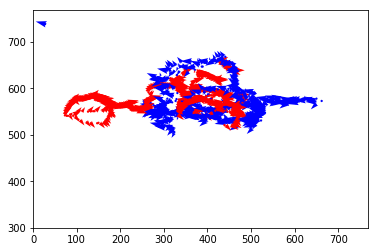

In [195]:
view(environment.agent_path,environment.enemy_path)

This is a set of vectors that point at the direction each agent moves to and also are centered at their position.
By using this technique we can study the behaviour that emerges. In this image we can see the agent did a circle at the begining and then went to the center. 

# The way the reward looks as a function of time. It will be used as an estiamte of Q value for future games. 

We define reward after the game
### Win
$\frac{reward+1}{2}$ = Updated Reward after win scenario
### Loose 
$\frac{reward}{2}$ = Updated Reward after fali scenario


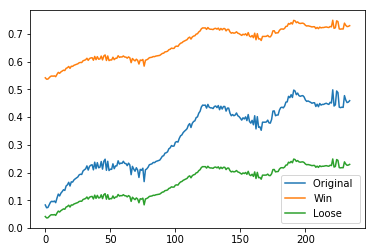

In [16]:
plt.plot([F_reward[i] for i in range(len(F_reward))]) # Original 
plt.plot([(F_reward[i]+1)/2 for i in range(len(F_reward))]) # Win 
plt.plot([(F_reward[i])/2 for i in range(len(F_reward))]) # Loose

plt.legend(('Original ', 'Win', 'Loose'))

# Other options 
Giving more weight to initial stages is equivalent to implementing the discount factor
$T$ is the total number of timesteps in the game, $t$ is the current timestep 
### Win
$(\frac{T-t}{T}+1)*Reward(t)$ = Updated $Reward(t)$ after win scenario
### Loose 
$(\frac{T-t}{10})*Reward(t)$ = Updated $Reward(t)$ after fali scenario

### For small values of  $t$ the term $(\frac{T-t}{T}+1)$ goes to two, and if $t$ is big then it goes to 1. Giving an advantage to initial action state values.

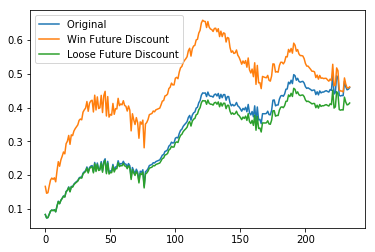

In [17]:
plt.plot([F_reward[i] for i in range(len(F_reward))]) # Original  
plt.plot([(((len(F_reward)-i)/len(F_reward))+1)*(F_reward[i]) for i in range(len(F_reward))]) # Win
plt.plot([(((len(F_reward)-i/10)/(len(F_reward))))*(F_reward[i]) for i in range(len(F_reward))]) # Loose

plt.legend(('Original ', 'Win Future Discount', 'Loose Future Discount'))

In [15]:
df_game=pd.DataFrame(F_next_state)

# First trivial optimum value 
With not enough samples for the algorithm to learn the result is a local optimum of going only to the right. After 100 iterations the model decreases his performance by searching for other winning strategies. This behaviour takes the agent from an initial prodigious performance to a slowly increasing improvement over time.

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 83.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

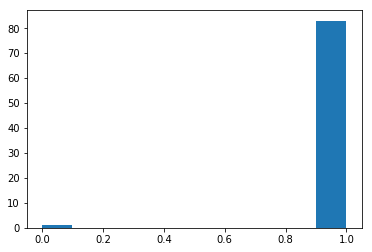

In [17]:
#0 is straight, 0.5 is left, 1 is right
plt.hist(df_game[11])

# For any given architecture we can use the pairs of (actionXvalue)|outcome to define a custom made Q function and see the effects.

In the following cells the Q values (as a function of time) can be customized to be symmetric (given positive outcome, or negative), increasing, decreasing. It can also be tuned for a certain type of episode where the final winning strategy is more agresive, or passive (only spinning) and that is why we have a final analysis of all winning scenarios, to be able to choose the most suitable. 

In [88]:
# To load a decent trained model 
#cnn = pickle.load(open("good_nn.sav", 'rb'))

In [148]:
# Or build your own 
nn_3 = Sequential()
nn_3.add(Dense(150, activation='relu', input_dim=12)) 
nn_3.add(Dense(150, activation='relu'))
nn_3.add(Dense(150, activation='relu'))
nn_3.add(Dropout(0.5))
nn_3.add(Dense(150, activation='relu'))
nn_3.add(Dropout(0.5))
nn_3.add(Dense(150, activation='relu'))
nn_3.add(Dense(150, activation='relu'))
nn_3.add(Dense(150, activation='relu'))
nn_3.add(Dense(1, activation='linear'))
nn_3.compile(loss='mse', optimizer=Adadelta()) # originally Adam

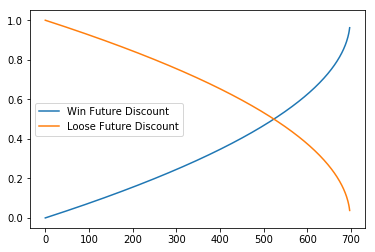

In [242]:
# Visualize the function for each value t.
#plt.plot([F_reward[i] for i in range(len(F_reward))]) # Original  
plt.plot([(-np.sqrt(len(F_reward)-i)/np.sqrt(len(F_reward))+1) for i in range(len(F_reward))]) # Win
plt.plot([(np.sqrt(len(F_reward)-i)/np.sqrt(len(F_reward))) for i in range(len(F_reward))]) # Loose

plt.legend(( 'Win Future Discount', 'Loose Future Discount'))


In [18]:
 # Train the model with that curve 
    #One Option 
for i in range(len(full_games_y)):
        if full_games_y[i][-1]>3: # If he wins 
            y = [(((len(full_games_y[i])-j*(0.5))/len(full_games_y[i]))+1)*(full_games_y[i][j]) for j in range(len(full_games_y[i]))]
            nn_3.fit(np.array(full_games_x[i]), np.array(y),epochs=3,verbose=0)
        
        if full_games_y[i][-1]<2:
            y=[(((len(full_games_y[i])-j*0.5)/(len(full_games_y[i]))))*(full_games_y[i][j]) for j in range(len(full_games_y[i]))]
            nn_3.fit(np.array(full_games_x[i]), np.array(y),epochs=3,verbose=0)
print("I know kung fu")

SyntaxError: invalid syntax (<ipython-input-18-53a12b850a73>, line 8)

In [246]:
 #Second
for i in range(len(full_games_y)):
        if full_games_y[i][-1]>3: # If he wins 
            y = [(np.sqrt(len(full_games_y[i])-j)/np.sqrt(len(full_games_y[i])))  for j in range(len(full_games_y[i]))]
            nn_3.fit(np.array(full_games_x[i]), np.array(y),epochs=3,verbose=0)
        
        if full_games_y[i][-1]<2:
            y=[(-np.sqrt(len(full_games_y[i])-j)/np.sqrt(len(full_games_y[i]))+1) for j in range(len(full_games_y[i]))]
            nn_3.fit(np.array(full_games_x[i]), np.array(y),epochs=3,verbose=0)
print("I know kung fu")

I know kung fu


In [247]:
### Test the model with 
NumberOfGames=10
epsilon = 0 # zero means model, 1 random.
percentage=[]
model_game=nn_3

In [248]:
u=0
for i in range(NumberOfGames):
    environment.reset() 
    F_next_state=[]
    
    F_reward=[]
    prd=[]
    u+=1
    j=1
    status=0
    action=0
    rand=True
    while status==0 or j<10:  
        if np.random.rand() <= epsilon:
            rand=True
        else:
            rand=False
            
        
        if rand:
            action=random.randrange(3)



        next_state = do_action(action,1,True)
        # action=NewAgent.act(1)

        status=next_state[0] # Normalized status 
        reward=next_state[1] # reward
        next_state = next_state[2:] # State variables
        next_state.append(action/2)

        F_next_state.append(next_state)
        F_reward.append(reward)
        exp_value=[]
        if rand:
                action=random.randrange(3)
        else:
            for k in range(3): # For each action 
                ex_reward=F_next_state[-1][:-1] 
                ex_reward.append(k/2)# Normalized action 
      
                prediction=model_game.predict(np.array(ex_reward).reshape(1, -1))  # Will evaluate the value of the next action 
                ex_reward=[]
                exp_value.append(prediction) # First element is first action and so on 
                
            action = np.argmax(exp_value)
        if len(F_next_state)>3000:
            status=1
        
        j=10
        

    percentage.append([0,1,1,1,1,1][int(F_reward[-1])])
   
    print("Game number",u,["Fail :(","win","win","win","win","win"][int(F_reward[-1])])
    

KeyboardInterrupt: 

In [ ]:
print("%",100*np.sum(percentage)/len(percentage),"Percent of games that wins")

# We can save all games and run a statistical analysis 

In [9]:
flat_list_x = []
for sublist in full_games_x:
    for item in sublist:
        flat_list_x.append(item)
FGames_x = pd.DataFrame(flat_list_x)

In [10]:
flat_list_y = []
for sublist in full_games_y:
    for item in sublist:
        flat_list_y.append(item)
FGames_y=pd.DataFrame(flat_list_y)

In [11]:
Win_y_index=FGames_y[FGames_y[0]>2].index.tolist()

## How many winning strategies are in the dataset 


There are aparently six ways to win according to the elbow technique. The clustering technique weas KMeans and to visualize each final stagte of the game in terms of similarity we use PCA. 

In [12]:
d=FGames_x.loc[Win_y_index]

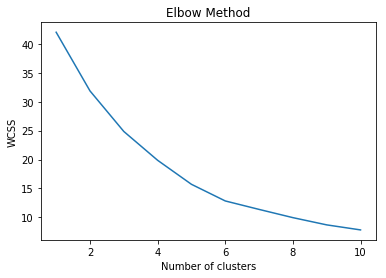

In [15]:
import cv2
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
X_tsne = TSNE().fit_transform(d)
X_pca = PCA().fit_transform(d)

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(d)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

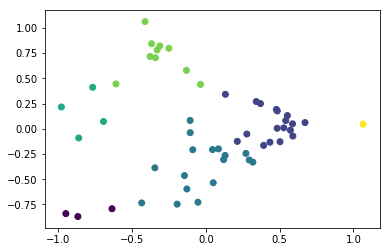

In [16]:
# We cluster the winning termianl stages, to see how it wins even if we have no previous images from episode 288 
kmeans = KMeans(n_clusters=6, random_state=0).fit(d)

plt.scatter(X_pca[:, 0], X_pca[:, 1],c=kmeans.labels_)

In [20]:
win_index=[]
for i in range(len(full_games_y)):
    if full_games_y[i][-1]>2:
        win_index.append(i)
Img_type=pd.DataFrame([list(win_index),list(kmeans.labels_)]).T

The most frequent win scenario is class 1.

In [18]:
Img_type.groupby(1).describe()

0                                                             
  count        mean         std    min     25%    50%     75%    max
1                                                                   
0   3.0  142.000000  187.933499    9.0   34.50   60.0  208.50  357.0
1  18.0  316.833333  169.861276   28.0  138.00  398.5  443.75  486.0
2  17.0  229.529412  133.841846   43.0  127.00  223.0  304.00  469.0
3   4.0  299.750000  161.953440   98.0  212.75  315.0  402.00  471.0
4  10.0  192.000000  166.301600   37.0   65.75  101.0  361.75  439.0
5   1.0  436.000000         NaN  436.0  436.00  436.0  436.00  436.0

In [183]:
Img_type.groupby(1).get_group(1) # We know the image for each class of scenario 

,0,1
1,28,1
2,29,1
14,106,1
15,107,1
16,108,1
24,228,1
29,288,1
31,328,1
33,368,1
39,429,1


### We can observe for each class of winning scenario the last 200 steps in the game. Represented as vectors with the position and direction of the agent (red) and enemy (blue). 
### Using this we overlay all images per class and obtain a single image that contains all common dynamics.

In [128]:
import cv2
def overlay(A,B,clas=1):
    background = cv2.imread(A)
    
    overlay = cv2.imread(B)
    added_image = cv2.addWeighted(background,0.5,overlay,0.5,0.0)
    
    cv2.imwrite('class_5.png', added_image)

In [131]:
clas=5
for i in list(Img_type.groupby(1).get_group(clas)[0]):
    if i >288:
        print('result_{}.png'.format(i))
        overlay('result_{}.png'.format(i),'class_5.png',clas=clas)
        

result_436.png


Populating the interactive namespace from numpy and matplotlib


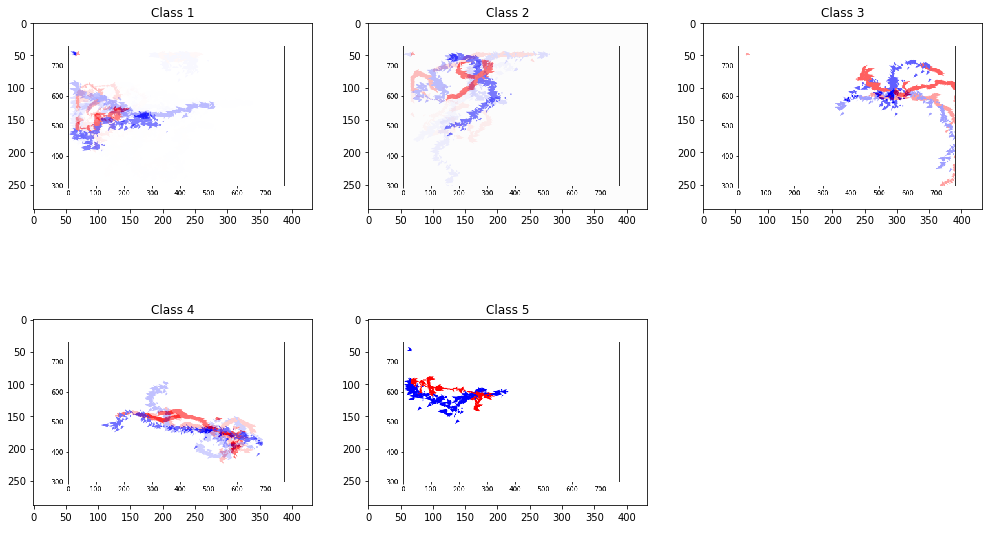

In [180]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, axs = plt.subplots(2,3, figsize=(17, 10))
axs[0][0].set_title('Class 1')
axs[0][0].imshow(mpimg.imread('class_1.png'))
plt.axis('off')

axs[0][1].set_title('Class 2')
axs[0][1].imshow(mpimg.imread('class_2.png'))

axs[0][2].set_title('Class 3')
axs[0][2].imshow(mpimg.imread('class_3.png'))

axs[1][0].set_title('Class 4')
axs[1][0].imshow(mpimg.imread('class_4.png'))

axs[1][1].set_title('Class 5')
axs[1][1].imshow(mpimg.imread('class_5.png'))

plt.axis('off')
plt.show()

